<a href="https://colab.research.google.com/github/21-501/marthala-Padmaja-/blob/main/final_handwriting_recognition_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt  # Correct import for matplotlib
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the images to the range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape the data to make it suitable for RNN
# Shape: (samples, time_steps, input_dim)
# We will treat each row of the image as a time step, so the shape is (28, 28)
x_train = x_train.reshape((-1, 28, 28))
x_test = x_test.reshape((-1, 28, 28))

# Convert the labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Check the shape of the dataset
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")


Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Training labels shape: (60000,)
Test labels shape: (10000,)


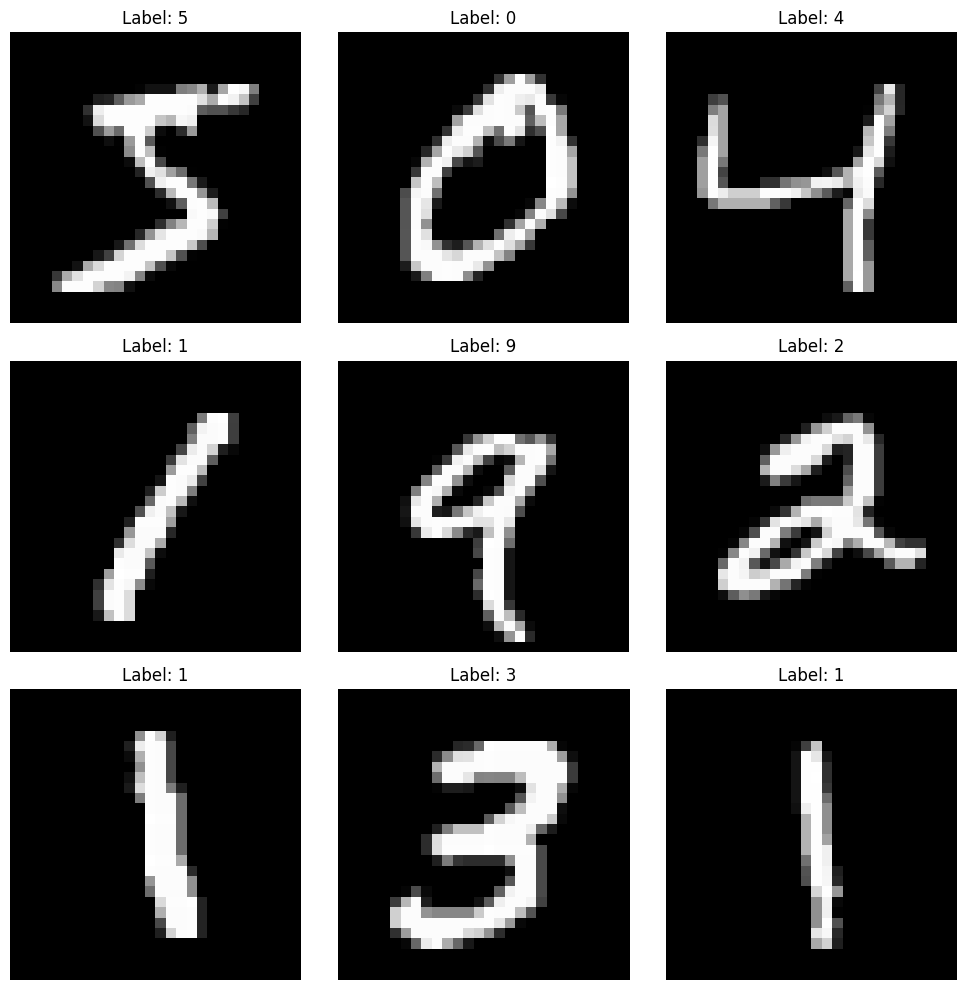

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):  # Show 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')  # Display image in grayscale
    plt.title(f"Label: {y_train[i]}")  # Display the label
    plt.axis('off')  # Turn off axis
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

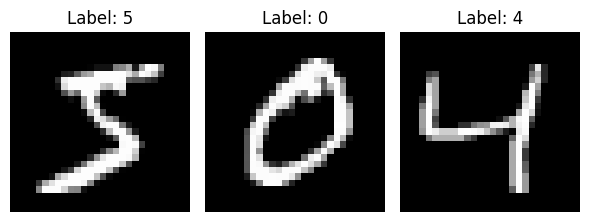

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Display 3 random images from the training set (for lighter computation)
plt.figure(figsize=(6, 6))  # Adjust figure size to fit fewer images
for i in range(3):  # Show 3 images instead of 9
    plt.subplot(1, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')  # Display image in grayscale
    plt.title(f"Label: {y_train[i]}")  # Display the label
    plt.axis('off')  # Turn off axis
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
# Calculate mean and standard deviation of the pixel values
mean_pixel_value = np.mean(x_train)
std_pixel_value = np.std(x_train)

print(f"Mean pixel value: {mean_pixel_value:.2f}")
print(f"Standard deviation of pixel value: {std_pixel_value:.2f}")


Mean pixel value: 33.32
Standard deviation of pixel value: 78.57


In [ ]:
# Check the shape of a single image
print(f"Shape of a single image: {x_train[0].shape}")


Shape of a single image: (28, 28)


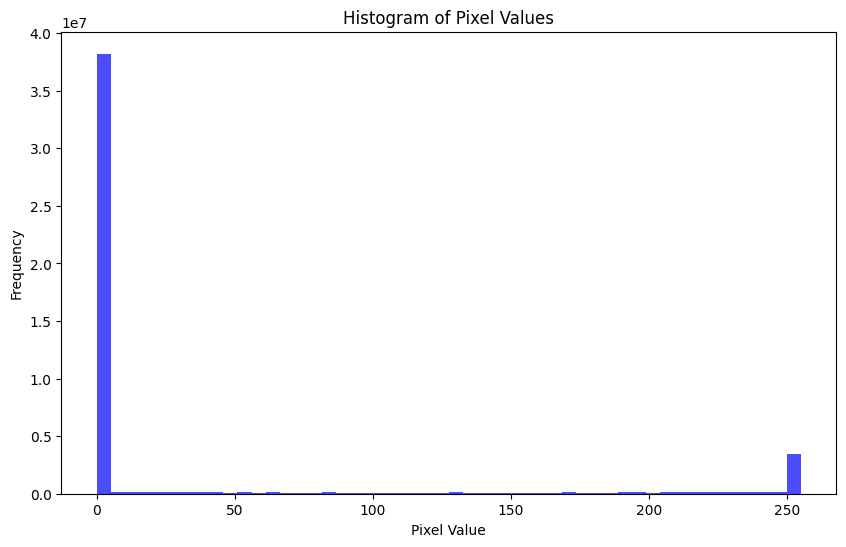

In [ ]:
# Flatten the training images to create a vector of pixel values
flat_images = x_train.reshape(-1, 28*28)  # Flatten each 28x28 image to a 784-length vector

# Calculate pixel-wise statistics across the whole dataset
mean_pixel = np.mean(flat_images, axis=0)
std_pixel = np.std(flat_images, axis=0)

# Plot histogram of pixel values
plt.figure(figsize=(10, 6))
plt.hist(flat_images.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


**highlighting darker images**

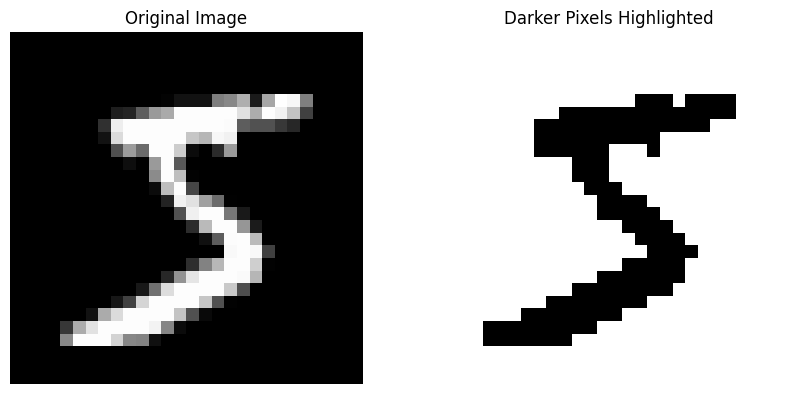

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Select the first image from the training set
image = x_train[0]  # This will select the first image in the dataset

# Create a mask for darker pixels (those with pixel values < 50)
threshold = 50
darker_pixels_mask = image < threshold

# Create a new image where darker pixels are shown in black (0) and others in white (255)
darker_pixels_image = np.zeros_like(image)
darker_pixels_image[darker_pixels_mask] = 255  # Set darker pixels to white for visibility

# Display the original image and the image highlighting the darker pixels
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Image showing only the darker pixels
plt.subplot(1, 2, 2)
plt.imshow(darker_pixels_image, cmap='gray')
plt.title("Darker Pixels Highlighted")
plt.axis('off')

plt.show()


In [ ]:
model = models.Sequential()

# Add LSTM layers
model.add(layers.LSTM(128, input_shape=(28, 28), return_sequences=False))

# Add Dense output layer (softmax activation for classification)
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          80,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,674 (319.04 KB)

 Trainable params: 81,674 (319.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.9755 - loss: 0.0710 - val_accuracy: 0.1487 - val_loss: 4.5554
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 50ms/step - accuracy: 0.9739 - loss: 0.0762 - val_accuracy: 0.1744 - val_loss: 4.4030
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.9734 - loss: 0.0744 - val_accuracy: 0.1352 - val_loss: 4.8343
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 84s 51ms/step - accuracy: 0.9755 - loss: 0.0699 - val_accuracy: 0.1250 - val_loss: 5.2325
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.9773 - loss: 0.0671 - val_accuracy: 0.0967 - val_loss: 5.9585
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.9772 - loss: 0.0655 - val_accuracy: 0.1198 - val_loss: 5.6426
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 50ms/step - accuracy: 0.9766 - loss: 0.0633 - val_accuracy: 0.1143 - val_loss: 5.4107
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.9798 - loss: 0.0598 - 

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)

print(f"Test accuracy: {test_acc}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9740 - loss: 0.0782
Test accuracy: 0.9781000018119812


In [ ]:
y_pred = model.predict(x_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)


NameError: name 'np' is not defined

In [ ]:
y_true = np.argmax(y_test, axis=1)

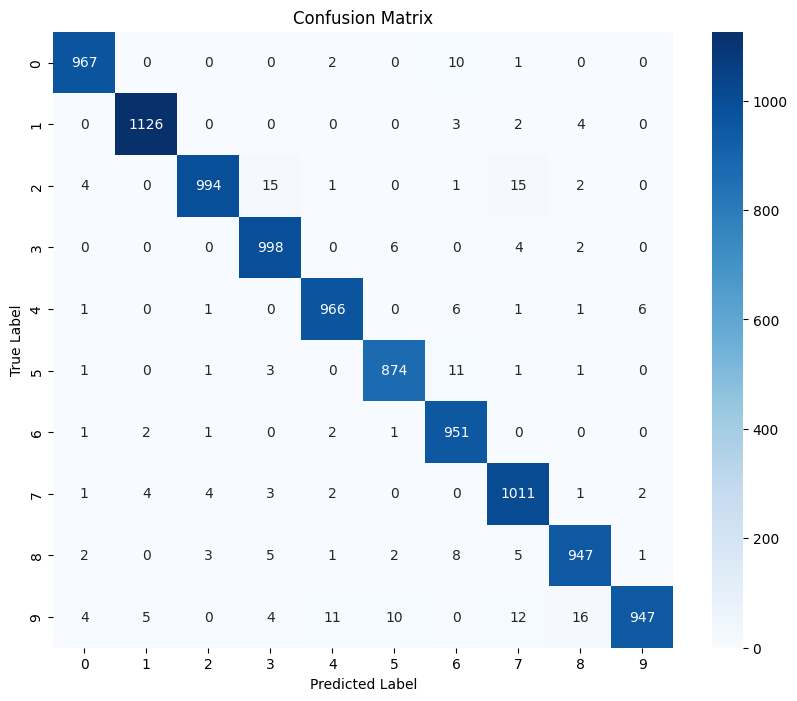

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

# Step 7: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 49s 51ms/step - accuracy: 0.9354 - loss: 0.1900 - val_accuracy: 0.9261 - val_loss: 0.2237
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 48ms/step - accuracy: 0.9434 - loss: 0.1709 - val_accuracy: 0.9296 - val_loss: 0.2159
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 84s 50ms/step - accuracy: 0.9437 - loss: 0.1644 - val_accuracy: 0.9282 - val_loss: 0.2161
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 48ms/step - accuracy: 0.9462 - loss: 0.1551 - val_accuracy: 0.9314 - val_loss: 0.2093
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 85s 51ms/step - accuracy: 0.9519 - loss: 0.1431 - val_accuracy: 0.9347 - val_loss: 0.1993
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 48ms/step - accuracy: 0.9524 - loss: 0.1401 - val_accuracy: 0.9378 - val_loss: 0.1968
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 47ms/step - accuracy: 0.9553 - loss: 0.1348 - val_accuracy: 0.9364 - val_loss: 0.2021
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 48ms/step - accuracy: 0.9595 - loss: 0.1254 - 

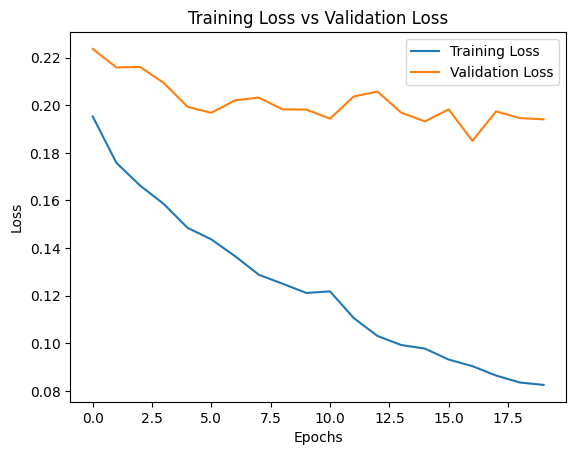

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model and capture the training history
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(x_test, y_test))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()